# Машинное обучение для текста с помощью BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

## Предварительный осмотр

In [1]:
#Импорт необходимых библиотек и компонентов
import pandas as pd

import torch

import transformers

import numpy as np

from tqdm import notebook

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import f1_score

from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.dummy import DummyClassifier

from math import sqrt

from sklearn.utils import shuffle

from catboost import CatBoostClassifier, Pool

In [2]:
df = pd.read_csv('C:/Users/andre/Downloads/toxic_comments.csv')

In [3]:
df

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


Обнаружен лишний столбец, скорей всего он содержит старые индексы массива, которые он имел до некой процедуры предобработки

In [4]:
#Удаляю лишний столбец
df = df.drop(['Unnamed: 0'],axis = 1)

array([[<AxesSubplot:title={'center':'toxic'}>]], dtype=object)

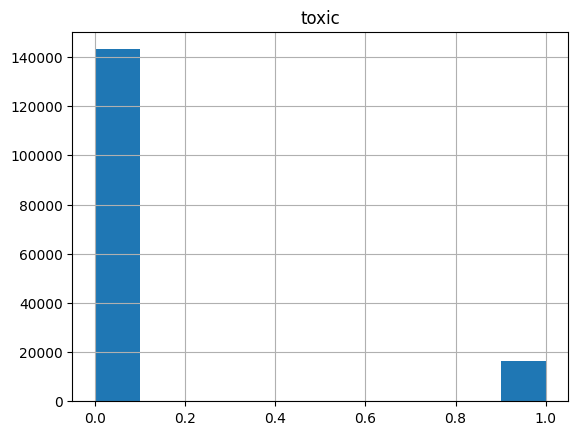

In [5]:
#Изучаю распределение
df.hist()

In [6]:
#Ищу пропуски и дубликаты
print(df.duplicated().sum())
print(df.isna().sum())

0
text     0
toxic    0
dtype: int64


Результаты первичного осмотра:

1)Слишком много строк для работы с BERT, их кодировка займет слишком много времени

2)Распределение целевого признака сильно смещено в сторону отрицательного значения, это испортит процесс предсказания

Для того чтобы решить эти две проблеммы я применю процедуру downsampling

## Предобработка

In [7]:
#Сокращаю массив, тк он всё равно слишком большой
df = df[0:2000]

<div class="alert alert-info"> Отредактировал, теперь функция применяется позже

In [8]:
model = transformers.AutoModel.from_pretrained('unitary/toxic-bert')
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
tokenized = df['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

In [10]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [11]:
config = transformers.BertConfig.from_json_file(
    'C:/Users/andre/Downloads/RuBert/bert_config.json')

In [12]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/20 [00:00<?, ?it/s]

In [13]:
df_bert = np.concatenate(embeddings)

In [14]:
df_bert = pd.DataFrame(data=df_bert)
df_bert['toxic'] = df['toxic'] 

In [15]:
train, test = train_test_split(df_bert, test_size = 0.25, random_state = 12345)

In [16]:
train_features = train.drop(['toxic'], axis = 1).reset_index(drop=True)
train_target = train['toxic'].reset_index(drop=True)
test_features = test.drop(['toxic'], axis = 1).reset_index(drop=True)
test_target = test['toxic'].reset_index(drop=True)

In [17]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat(
    [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
    [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(
    features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled
                                              

In [18]:
train_features, train_target = downsample(train_features, train_target, 0.1)

## Тест моделей

In [19]:
#Тестирую лес
forest_grid_space = {'n_estimators': [300, 500], 'max_depth': [None, 1, 2]}
model = RandomForestClassifier(random_state = 12345)
forest_grid = GridSearchCV(model,param_grid=forest_grid_space, scoring = 'f1', n_jobs=-1)
model_grid = forest_grid.fit(train_features, train_target)
print('Лучшие гиперпараметры это: '+str(model_grid.best_params_))
print('Лучший результат - '+str(model_grid.best_score_))

Лучшие гиперпараметры это: {'max_depth': None, 'n_estimators': 300}
Лучший результат - 0.9876893939393939


In [20]:
#Тестирую древо
tree_grid_space ={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11],
           "min_samples_leaf":[1,2,3,4,5,6],
           "min_weight_fraction_leaf":[0.2,0.3,0.4]}
model = DecisionTreeClassifier(random_state = 12345)
tree_grid = GridSearchCV(model,param_grid=tree_grid_space,scoring='f1')
model_grid = tree_grid.fit(train_features, train_target)
print('Лучшие гиперпараметры это: '+str(model_grid.best_params_))
print('Лучший результат - '+str(model_grid.best_score_))

Лучшие гиперпараметры это: {'max_depth': 1, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.2, 'splitter': 'best'}
Лучший результат - 0.9842214640198511


In [21]:
#Тестирую лин.регрессию
log_grid_space ={'penalty':['l1','l2'], 
              'C':[1, 10, 100, 1000],
                'max_iter':[100, 200, 300]}
model = LogisticRegression(random_state = 12345)
linear_grid = GridSearchCV(model,param_grid=log_grid_space,scoring='f1', n_jobs=-1)
model_grid = linear_grid.fit(train_features, train_target)
print('Лучшие гиперпараметры это: '+str(model_grid.best_params_))
print('Лучший результат - '+str(model_grid.best_score_))

Лучшие гиперпараметры это: {'C': 1, 'max_iter': 100, 'penalty': 'l2'}
Лучший результат - 0.9905738705738706


C:\Users\andre\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.99057387        nan 0.99057387        nan 0.99057387
        nan 0.99057387        nan 0.99057387        nan 0.99057387
        nan 0.99057387        nan 0.99057387        nan 0.99057387
        nan 0.99057387        nan 0.99057387        nan 0.99057387]
  warnings.warn(


In [22]:
#Тестирую catboost
cat_grid_space ={'iterations' : [2,3,4],
                'depth' : [2,3,4]}
model = CatBoostClassifier()
cat_grid = GridSearchCV(model,param_grid=cat_grid_space,scoring='f1')
model_grid = cat_grid.fit(train_features, train_target)
print('Лучшие гиперпараметры это: '+str(model_grid.best_params_))
print('Лучший результат - '+str(model_grid.best_score_))

Learning rate set to 0.5
0:	learn: 0.1966335	total: 170ms	remaining: 170ms
1:	learn: 0.0688936	total: 189ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.1958794	total: 8.46ms	remaining: 8.46ms
1:	learn: 0.0684898	total: 16ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.1432232	total: 8.78ms	remaining: 8.78ms
1:	learn: 0.0572853	total: 16.1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.1580286	total: 8.67ms	remaining: 8.67ms
1:	learn: 0.0502305	total: 16.1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.1842886	total: 8.8ms	remaining: 8.8ms
1:	learn: 0.0991423	total: 17.2ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.1966335	total: 8.5ms	remaining: 17ms
1:	learn: 0.0688936	total: 15.8ms	remaining: 7.91ms
2:	learn: 0.0398475	total: 23ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.1958794	total: 8.59ms	remaining: 17.2ms
1:	learn: 0.0684898	total: 17.2ms	remaining: 8.58ms
2:	learn: 0.0388327	total: 24.7ms	remaining: 0us
Learning rate set to 0.5
0

Логистическая Регрессия показала себя лучше всего, её я и использую в финальном тесте

## Финальный тест

In [23]:
predictions = linear_grid.best_estimator_.predict(test_features)
print('Финальный f1 -',f1_score(test_target, predictions))

Финальный f1 - 0.8347826086956522


In [24]:
model = model = DummyClassifier(strategy = 'constant', constant = 1, random_state = 12345)
model.fit(train_features, train_target)
predictions = model.predict(test_features)
print('f1 примитивного алгоритма',f1_score(test_target, predictions))

f1 примитивного алгоритма 0.18181818181818182


В данном проекте я построил модель, которая предсказывала токсичность текста, и показала результат в 82.5 f1.Я выполнил это с помощью алгоритма BERT, который преобразовал текст в формат, пригодный для машинного обучения